In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import os
import sys
import time
sys.path.extend(['..'])

import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.datasets import make_moons

from torch.nn.functional import softmax as torch_softmax

from models import DNN
from utils import plot_toy_regions

In [4]:
dev = torch.device('cuda:1')

## Toy example: 2D Classification 

In [5]:
X, y = make_moons(n_samples=200, noise=0.1)

X_train = torch.as_tensor(X, dtype=torch.float32)
y_train = torch.as_tensor(y, dtype=torch.float32).view(-1, 1)

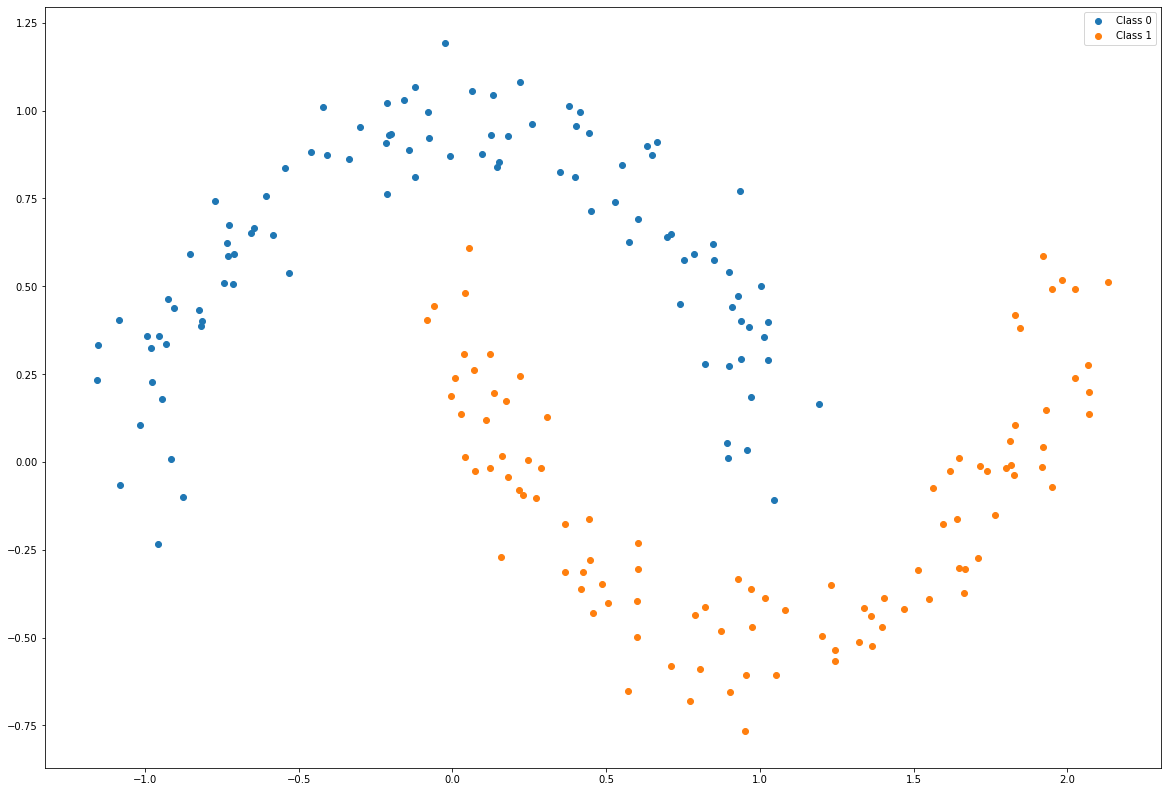

In [6]:
fig, ax = plt.subplots(figsize=(20, 14))

ax.scatter(X[y==0, 0], X[y==0, 1], label='Class 0')
ax.scatter(X[y==1, 0], X[y==1, 1], label='Class 1')
ax.legend()

plt.show();

### DNN overfitting:

In [7]:
epochs = 5000

In [8]:
# Define forward pass
dnn = DNN(d_in=2, d_out=1, hidden_size=[10, 10])

# Initialized set of parameters
Wb = dnn.gen_params()

# Init optimizer and loss function
optimizer = torch.optim.SGD([Wb], lr=1e-3)
loss = nn.BCEWithLogitsLoss(reduction='sum')

In [9]:
_loss = []
for e in range(epochs):
    
    z = dnn(X_train, Wb)
    
    curr_loss = loss(z, y_train)
    
    curr_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    
    _loss.append(curr_loss.item())

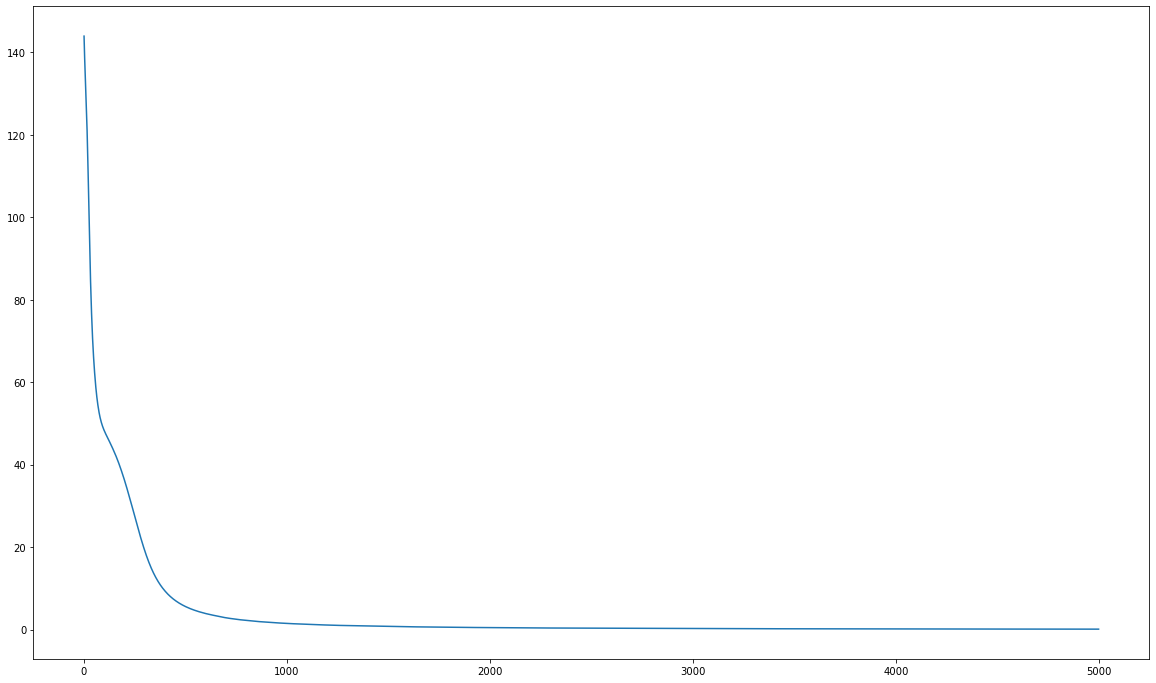

In [10]:
fig, ax = plt.subplots(figsize=(20, 12))

ax.plot(_loss)

plt.show()

In [11]:
def predict(X, Wb):
    if not torch.is_tensor(X):
        X = torch.as_tensor(X, dtype=torch.float32, device=Wb.device)
    z = dnn(X, Wb)
    return torch.sigmoid(z).cpu().detach().numpy()

We have perfect accuracy:

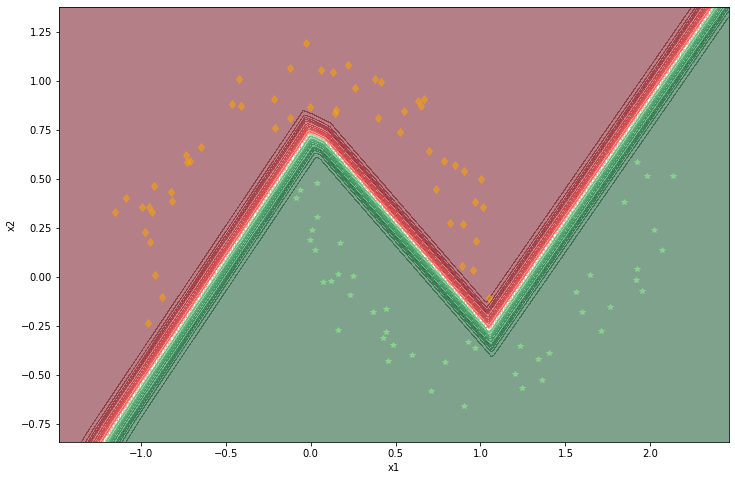

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))


ax = plot_toy_regions(X_train[:100], y_train[:100],
                      lambda x: predict(x, Wb),
                      ax=ax)
plt.show();

But we make confident predictions on regions of input space where we have seen no data.

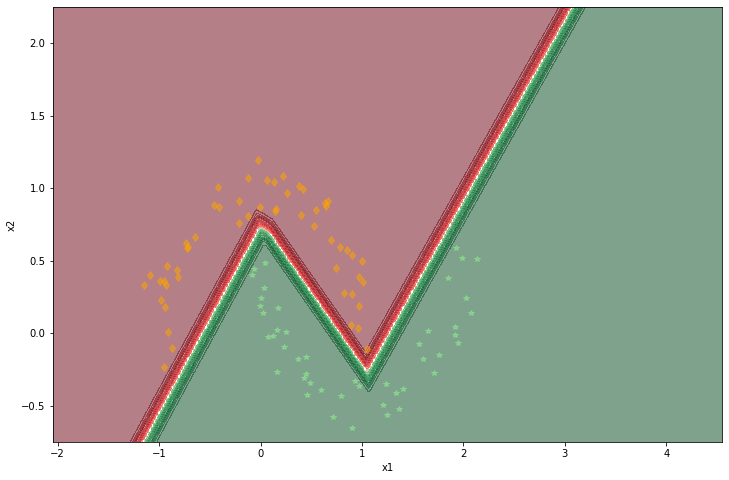

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))


ax = plot_toy_regions(X_train[:100], y_train[:100],
                      lambda x: predict(x, Wb),
                      ax=ax,
                      xlims=(-1.5, 4),
                      ylims=(-0.5, 2))
plt.show();

### Model Average

#### One solution is to average over models that explain well the data:

In [14]:
n_models = 10

# Initialized set of parameters
Wbs = [dnn.gen_params() for _ in range(n_models)]

# Init optimizer and loss function
optimizer = torch.optim.SGD(Wbs, lr=1e-2)
loss = nn.BCEWithLogitsLoss(reduction='sum')

In [15]:
_loss = [[] for _ in range(n_models)]
for e in range(epochs):
    curr_loss = []
    for i, Wb in enumerate(Wbs):
        z = dnn(X_train, Wb)
    
        curr_loss.append(loss(z, y_train))
        
        _loss[i].append(curr_loss[-1])
    
    sum(curr_loss).backward()
    optimizer.step()
    optimizer.zero_grad()

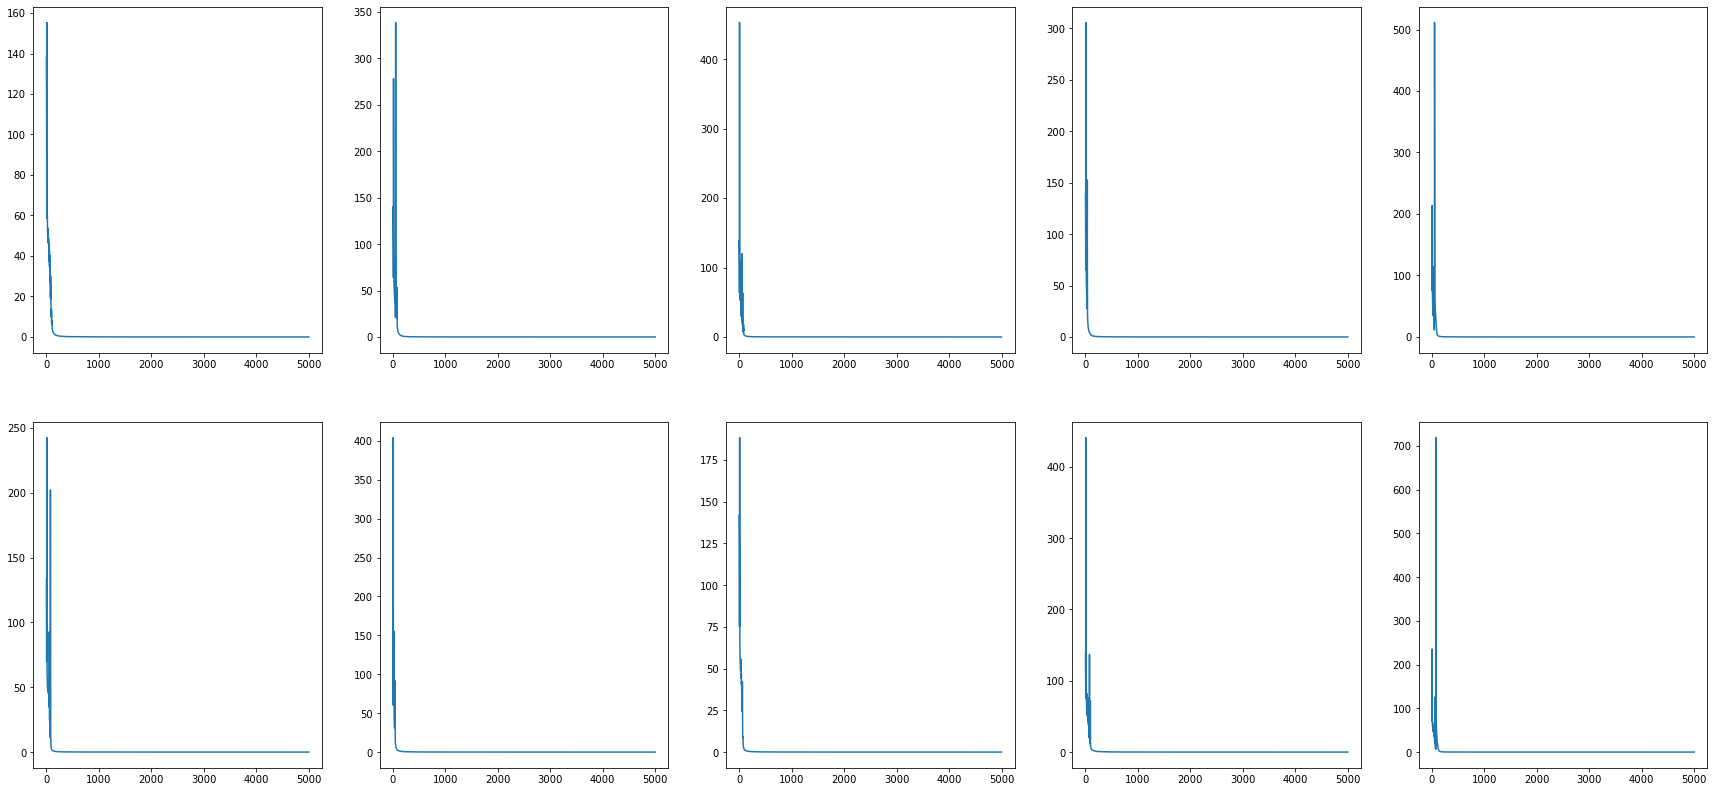

In [16]:
fig, ax = plt.subplots(2, 5, figsize=(30, 14))

for i in range(n_models):

    ax[i//5, i%5].plot(_loss[i])

plt.show()

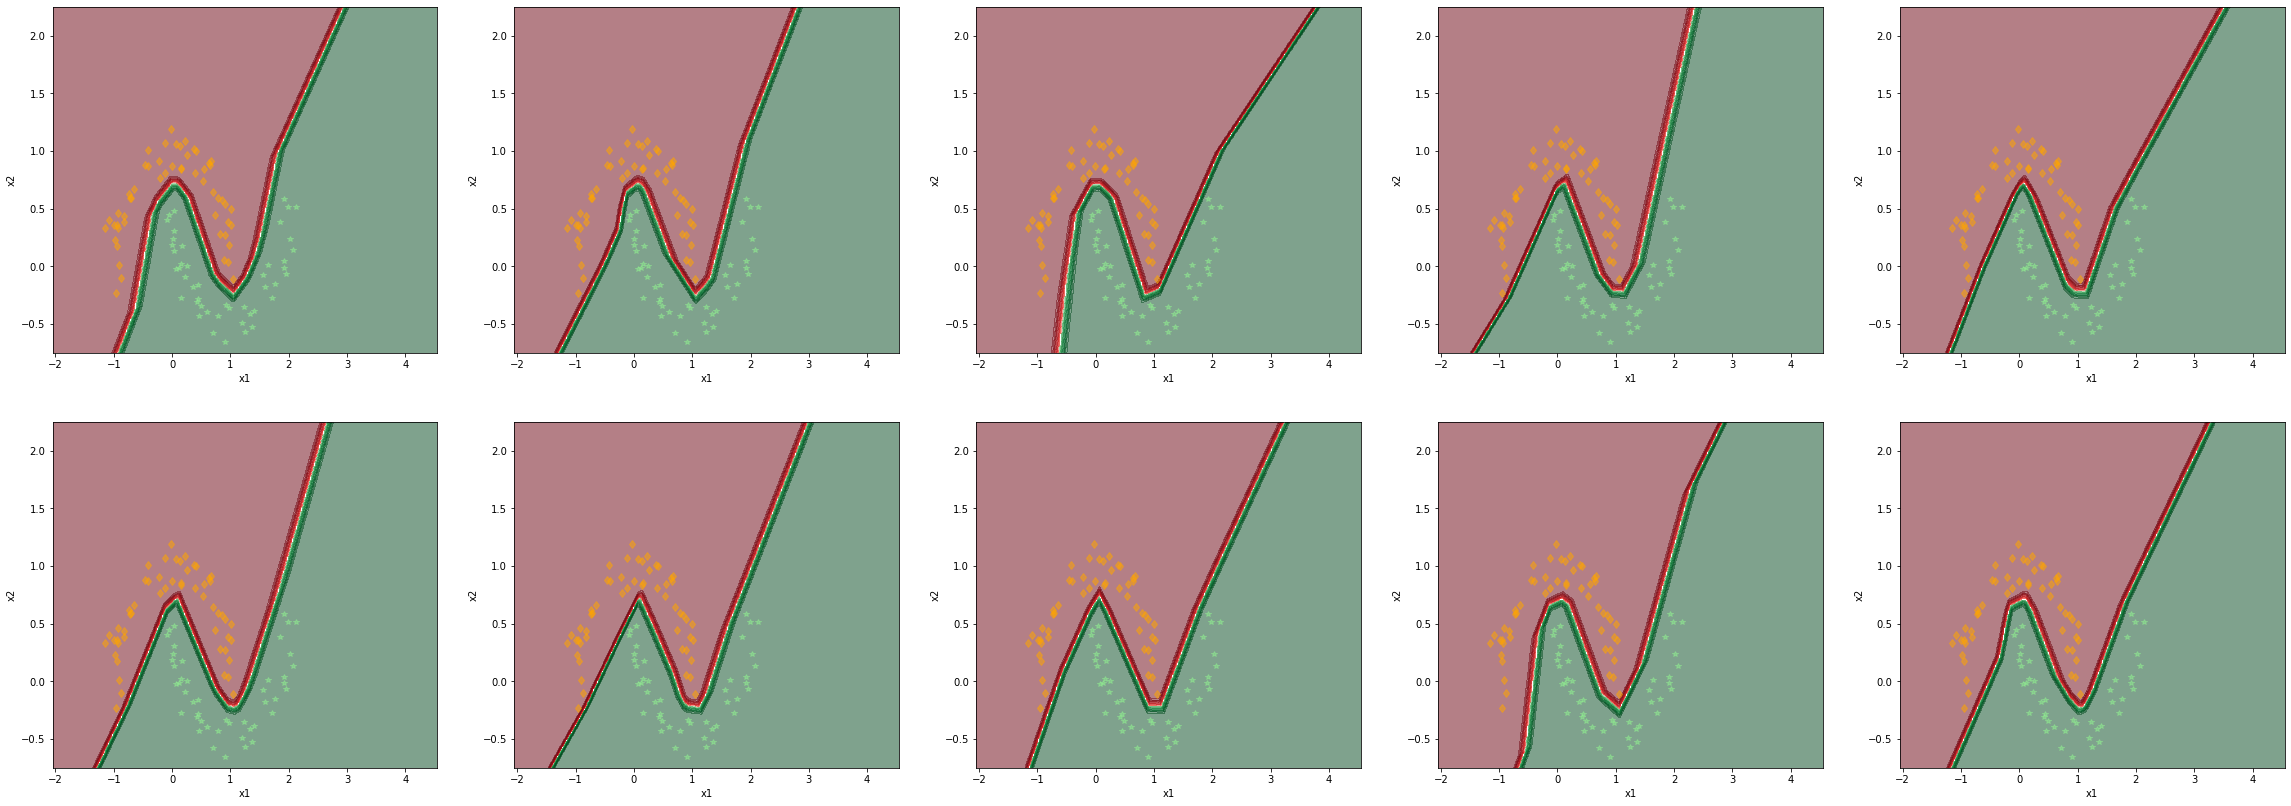

In [17]:
fig, ax = plt.subplots(2, 5, figsize=(40, 14))

for i in range(n_models):
    ax[i//5, i%5] = plot_toy_regions(X_train[:100], y_train[:100],
                          lambda x: predict(x, Wbs[i]),
                          ax=ax[i//5, i%5],
                          xlims=(-1.5, 4),
                          ylims=(-0.5, 2))
plt.show();

In [18]:
def predict_enseble(X, Wbs):
    preds = []
    if not torch.is_tensor(X):
        X = torch.as_tensor(X, dtype=torch.float32, device=Wbs[0].device)
    for Wb in Wbs:
        z = dnn(X, Wb)
        preds.append(torch.sigmoid(z).cpu().detach().numpy())
    
    return sum(preds)/len(preds)

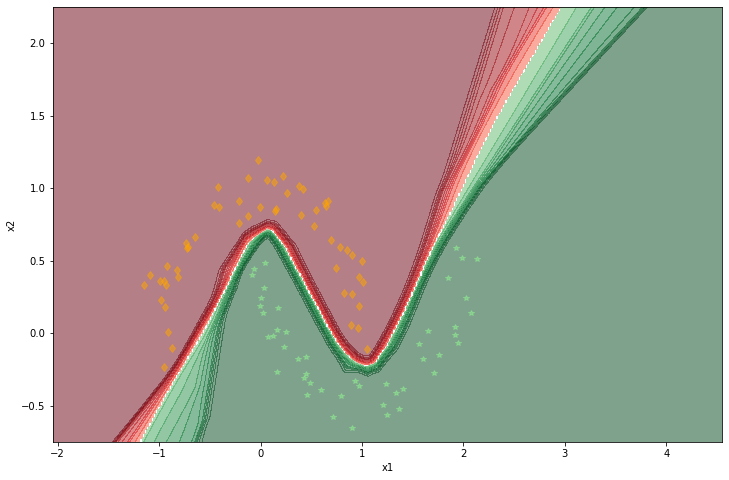

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))


ax = plot_toy_regions(X_train[:100], y_train[:100],
                      lambda x: predict_enseble(x, Wbs),
                      ax=ax,
                      xlims=(-1.5, 4),
                      ylims=(-0.5, 2))
plt.show();

### Bayesian Model Average

Bayesian Inference allows to make predictions averagins marginalizing over the parameter space of $\theta$ the posterior distribution of $\theta$ having observed some data $\mathcal{D}$:

$$
p(y | x, \mathcal{D}) = \int p(y| x, \theta)p(\theta|\mathcal{D})d\theta
$$

However, $p(\theta|\mathcal{D})$ has no tractable solution for DNNs and we resort to approximate methods instead.

### VI

Approximate the parameters $\phi$ of a variational distribution $q_\phi(\theta)$ such that:
$$
\begin{align}
\phi^* &= \arg\min_\phi D_{KL} [q_\phi(\theta) || p(\theta|\mathcal{D})] \\
&= \arg\min_\phi D_{KL} [ q_\phi(\theta) || \frac{p(\mathcal{D} || \theta)p(\theta)}{p(\mathcal{D})} ] \\
&= \arg\min_\phi \mathbb{E}_{q_\phi(\theta)}[-\log p(\mathcal{D} || \theta)] + D_{KL} [ q_\phi(\theta) || p(\theta) ]
\end{align}
$$

#### Mean Field Gaussian

Standard Normal prior:

In [65]:
## Initialize variational parameters
mu = dnn.gen_params()
log_var = torch.randn_like(mu) - 5

In [66]:
def factorized_gauss_KLD(qmu, qlog_var, pmu, plog_var):
    return 0.5 * torch.sum(torch.exp(qlog_var - plog_var)
                           + (qmu - pmu)**2/torch.exp(plog_var) - 1
                           + (plog_var - qlog_var))

In [67]:
def sample_factorized_gauss(mu, log_var, n_samples):
    Z = mu.view(1, -1) + torch.randn((n_samples, mu.shape[0]), device=mu.device)*torch.sqrt(torch.exp(log_var))
    return Z

In [68]:
epochs = 10000
MC_samples = 150

optimizer = torch.optim.Adam([mu, log_var], lr=1e-4)
nll = nn.BCEWithLogitsLoss(reduction='sum')

In [69]:
_elbo = []
_nlls = []
_KL = []
for e in range(epochs):
    
    Wbs = sample_factorized_gauss(mu, log_var, MC_samples)
    
    _nll = 0.0
    
    for Wb in Wbs:
    
        z = dnn(X_train, Wb)
    
        _nll += nll(z, y_train)
        
    _nll /= MC_samples
    
    KL = factorized_gauss_KLD(mu, log_var, torch.tensor([0.0]), torch.tensor([-5.0]))
    nelbo = _nll + KL
    
    nelbo.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    
    _elbo.append(-nelbo.item())
    _nlls.append(_nll.item())
    _KL.append(KL.item())

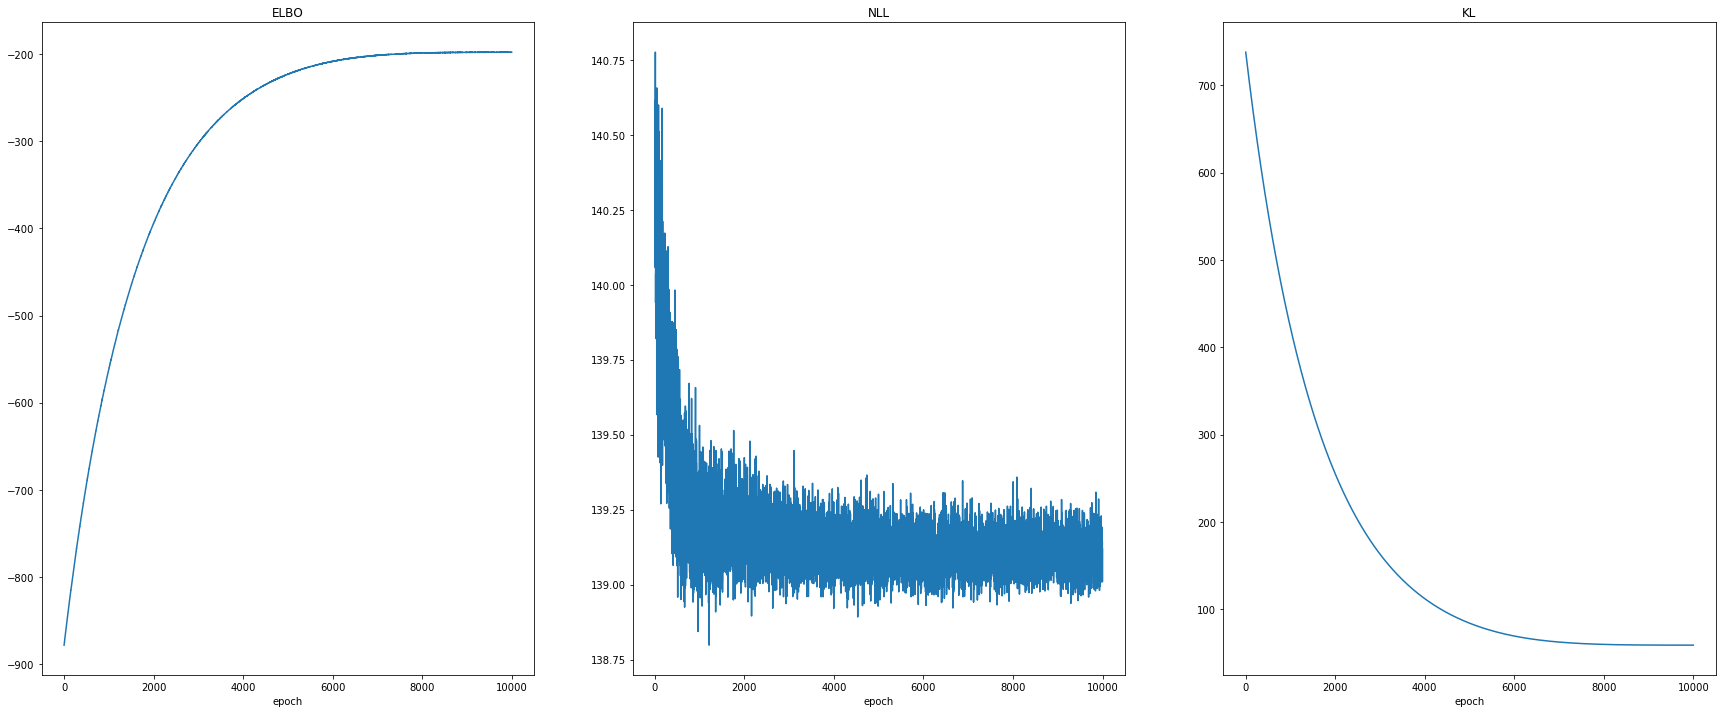

In [70]:
fig, ax = plt.subplots(1, 3, figsize=(30, 12))

ax[0].plot(_elbo)
ax[0].set_title('ELBO')
ax[0].set_xlabel('epoch')

ax[1].plot(_nlls)
ax[1].set_title('NLL')
ax[1].set_xlabel('epoch')

ax[2].plot(_KL)
ax[2].set_title('KL')
ax[2].set_xlabel('epoch')


plt.show()

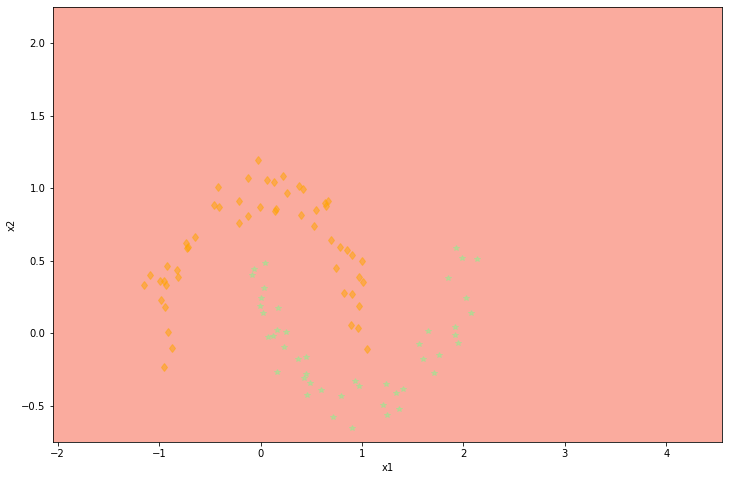

In [78]:
Wbs = sample_factorized_gauss(mu, log_var, 100)

fig, ax = plt.subplots(figsize=(12, 8))


ax = plot_toy_regions(X_train[:100], y_train[:100],
                      lambda x: predict_enseble(x, Wbs),
                      ax=ax,
                      xlims=(-1.5, 4),
                      ylims=(-0.5, 2))
plt.show();

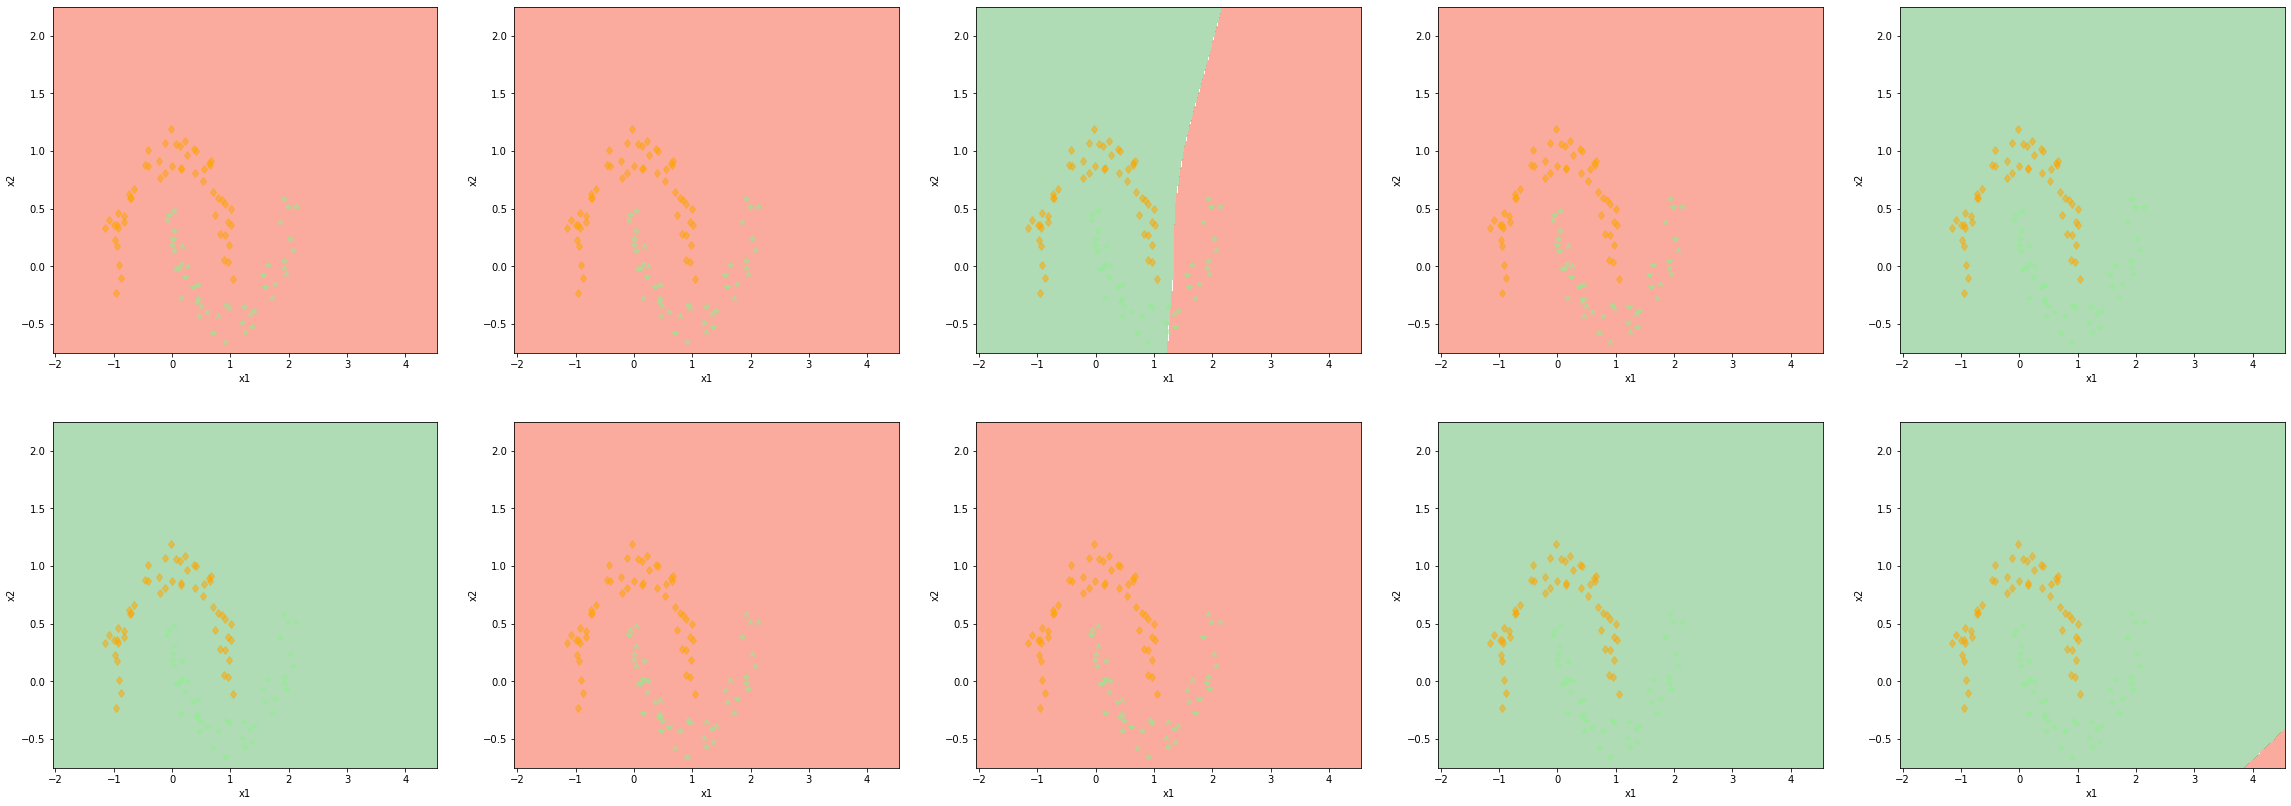

In [72]:
Wbs = sample_factorized_gauss(mu, log_var, 10)


fig, ax = plt.subplots(2, 5, figsize=(40, 14))

for i in range(n_models):
    ax[i//5, i%5] = plot_toy_regions(X_train[:100], y_train[:100],
                          lambda x: predict(x, Wbs[i]),
                          ax=ax[i//5, i%5],
                          xlims=(-1.5, 4),
                          ylims=(-0.5, 2))
plt.show();

In [75]:
mu

Parameter containing:
tensor([-7.3124e-05,  2.6724e-05,  2.1508e-06, -2.3114e-05,  6.8946e-03,
         1.3618e-04, -1.7184e-04,  1.9540e-05,  1.7924e-05,  2.3760e-05,
         5.0268e-03, -2.8511e-06, -4.3404e-05, -4.8471e-04, -1.5936e-05,
         1.9442e-03, -6.4885e-06, -4.4818e-05,  1.6686e-05,  1.1958e-03,
        -5.8894e-05, -3.4379e-05,  1.0041e-05,  2.5889e-06, -9.0419e-06,
         1.9771e-06, -8.1377e-06, -2.1843e-05,  8.7397e-05,  2.2870e-05,
         4.5668e-05,  1.8812e-05, -2.8508e-05,  5.6100e-07,  4.7707e-05,
        -1.7993e-06,  3.4821e-06,  3.3398e-05, -8.7598e-05, -6.7867e-06,
        -5.0019e-05,  1.9843e-05, -1.8487e-05, -3.4184e-06, -7.5681e-05,
         4.6431e-06, -2.8970e-05, -1.4696e-05, -2.7851e-06,  2.7628e-06,
        -6.8050e-06, -4.3265e-05, -3.2381e-05,  7.0536e-05, -2.7499e-05,
        -2.0682e-05,  3.0266e-05,  7.2500e-05, -2.5802e-05, -1.7290e-05,
        -4.8217e-05, -5.7831e-06, -3.6452e-05, -6.0399e-07, -1.8161e-05,
        -4.8741e-05, -3.0058e

In [76]:
log_var

tensor([-3.4875, -5.6916, -5.8593, -5.6200, -5.4789, -4.8253, -4.9836, -4.5416,
        -6.0158, -4.9419, -6.2911, -6.3024, -4.8198, -4.5677, -4.2536, -4.7885,
        -6.2592, -4.5153, -3.5429, -5.8627, -7.3463, -3.6036, -4.3135, -5.7705,
        -2.5772, -5.0328, -5.3889, -4.6291, -6.8223, -5.8953, -6.7219, -5.9404,
        -4.8406, -4.8375, -5.0871, -1.8323, -6.8508, -4.5570, -3.4586, -3.5525,
        -6.3280, -3.2266, -5.0671, -5.1248, -4.6746, -6.3760, -4.7200, -4.7433,
        -5.1922, -4.0881, -5.1891, -3.1081, -6.8400, -6.0427, -3.2587, -5.8038,
        -5.4283, -4.7005, -5.9439, -4.7650, -2.9523, -6.3108, -6.8014, -3.2286,
        -5.1761, -4.7482, -4.6200, -4.9014, -5.2604, -4.4923, -4.9426, -5.2305,
        -4.7489, -4.6674, -6.2909, -3.4831, -5.6760, -5.3037, -6.1196, -5.0322,
        -3.5396, -3.5693, -5.9400, -4.5614, -4.0321, -5.5832, -5.7511, -3.0537,
        -5.1272, -5.1177, -5.6701, -4.4636, -4.2252, -6.0773, -5.1073, -3.7543,
        -4.5020, -4.3794, -6.7862, -5.84